In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import numpy as np
import pandas as pd
import scipy.optimize

from datetime import datetime
import pytz

import gm2
import trfp

central_time = pytz.timezone('US/Central')

matplotlib.rc('xtick', labelsize=10)     
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes', titlesize=16)
matplotlib.rc('axes', labelsize=12)

# sns.set(style="darkgrid")
# sns.set(rc={'figure.figsize':(7,4.33)})

Welcome to JupyROOT 6.12/04


In [2]:
tr_run = gm2.Trolley([3956])
fp_run = gm2.FixedProbe([3956])

In [5]:
out = fp_run.getBasics()



Reading event 2630/2634 99.85%    
loop done: 100%                                    


In [10]:
out = fp_run.id
print out['layer']

print ord('B')

[84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 66 66 66 66 66 66
 66 66 66 66 66 66 66 66 66 66 66 66 84 84 84 84 84 84 84 84 84 84 84 84
 84 84 84 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 84 84 84 84 84 84
 84 84 84 84 84 84 84 84 84 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66
 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 66 66 66 66 66 66
 66 66 66 66 66 66 66 66 66 66 66 66 84 84 84 84 84 84 84 84 84 84 84 84
 84 84 84 84 84 84 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66
 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 66 66 66 66 66 66 66 66 66
 66 66 66 66 66 66 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 66 66 66
 66 66 66 66 66 66 66 66 66 66 66 66 84 84 84 84 84 84 84 84 84 84 84 84
 84 84 84 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66 84 84 84 84 84 84
 84 84 84 84 84 84 84 84 84 66 66 66 66 66 66 66 66 66 66 66 66 66 66 66
 84 84 84 84 84 84 84 84 84 84 84 84 84 84 84 66 66 66 66 66 66 66 66 66
 66 66 66 66 66 66 84 84 84 84 84 84 84 84 84 84 84

In [11]:
tr3956 = trfp.TrolleyRun(3956)
corrected_df = trfp.remove_trolley_effect(tr3956)

Reading event 8780/8781 99.99%     
loop done: 100%                                    
Reading event 2630/2634 99.85%       
loop done: 100%                                    
Finished calculating all moments for 4385 events.                                                     
Finished removing trolley images from 4385 events.             


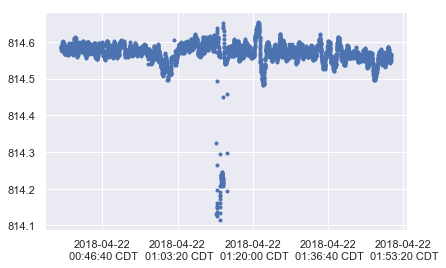

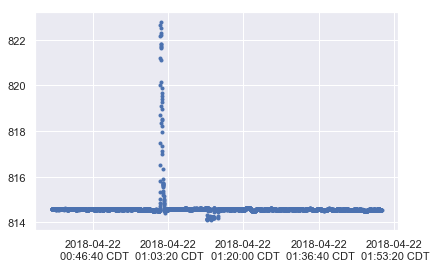

In [12]:
sns.set(style="darkgrid")

st_m = 'st30,m1'

fig, ax = plt.subplots()
plt.plot(corrected_df.index,corrected_df[st_m]/61.79, '.')
xticks = ax.get_xticks()
ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z') for tm in xticks], rotation=0)
fig.set_size_inches(6.5, 4)
plt.show()

fig, ax = plt.subplots()
plt.plot(tr3956.moment_df.index,tr3956.moment_df[st_m]/61.79, '.')
xticks = ax.get_xticks()
ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z') for tm in xticks], rotation=0)
fig.set_size_inches(6.5, 4)
plt.show()